In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#Random seed used in R was 7
random_seed=7

In [3]:
#read input data
#data=pd.read_csv('GS_majority_vote.csv') #all 986 synsets
#data=pd.read_csv('GS_All_Agreed.csv') #839 synsets where all annotators agree
data=pd.read_csv('AA_norm.csv')

In [4]:
#dataframes for each domain for local models
d_tools=pd.DataFrame(data.loc[data['domain_x']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['domain_x']=='fruit'])
d_music=pd.DataFrame(data.loc[data['domain_x']=='music'])
d_furn=pd.DataFrame(data.loc[data['domain_x']=='furn'])
d_garm=pd.DataFrame(data.loc[data['domain_x']=='garm'])

In [5]:
#dataframe for reproducing results from original 3 domains (without furniture and garments)
three=data[data['domain_x']!='furn']

In [6]:
fmt=three[three['domain_x']!='garm']

In [7]:
list(data)

['Unnamed: 0',
 'Unnamed: 0_x',
 'Unnamed: 0.1',
 'Unnamed: 0.1.1',
 'Synsets',
 'domain_x',
 'nrhypos_x',
 'nrdirhypers_x',
 'nrpartrels_x',
 'depthfromtopsynset_x',
 'glosslength_x',
 'minwordlength_x',
 'nroflemmas_x',
 'polyscore_max_x',
 'ngrams_last_mean',
 'nrpartrels_normalised_x',
 'depthfromtopsynset_normalised_x',
 'glosslength_normalised_x',
 'res_ngrams_2008_mean',
 'ngrams_2008_mean_log_y',
 'ngrams_sum08',
 'ngrams_max08',
 'All_CHILDES_mean',
 'All_CHILDES_mean_log',
 'CHILDES_sum',
 'CHILDES_Sum_log',
 'CHILDES_max',
 'CHILDES_max_log',
 'KBNC_mean',
 'KBNC_mean_log',
 'KBNC_Sum',
 'KBNC_Sum_log',
 'KBNC_max',
 'KBNC_max_log',
 'CABNC_mean',
 'CABNC_mean_log',
 'CABNC_sum',
 'CABNC_Sum_log',
 'CABNC_max',
 'CABNC_max_log',
 'BNC_mean',
 'BNC_mean_log',
 'BNC_sum',
 'BNC_Sum_log',
 'BNC_max',
 'BNC_max_log',
 'A1_Label',
 'A2_Label',
 'A3_Label',
 'MV',
 'vote_x',
 'CHILDES_Rel_mean',
 'KBNC_Rel_mean',
 'CABNC_Rel_mean',
 'BNC_Rel_mean',
 'CHILDES_Rel_mean_log',
 'KBNC_

In [10]:
#set features and target variable
features=[ 
    'ngrams_last_mean',
 'dir_hypers_normalised',
 'hypos_normalised',
 'nrpartrels_normalised_x',
 'depthfromtopsynset_normalised_x',
 'glosslength_normalised_x',
 'minwordlength_x',
 'nroflemmas_x',
 'polyscore_max_x'
]
target=['vote_x']

In [11]:
#set domains 
X=np.array(data[features])
y= np.array(data[target] )
#X=np.array(fmt[features])
#y= np.array(fmt[target] )
#X = np.array(d_music[features])
#y = np.array(d_music[target])
#X=np.array(d_tools[features])
#y=np.array(d_tools[target])
#X=np.array(d_fruit[features])
#y= np.array(d_fruit[target])
#X=np.array(d_furn[features])
#y= np.array(d_furn[target])
#X=np.array(d_garm[features])
#y= np.array(d_garm[target])

In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  77  78  79  80  81  82  83  84  85  86  87  88  89  90  92  93  94
  95  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 121 122 123 124 125 126 127 128 129 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 158 159 161 163 164 165 166 167 168 169 170 171 172
 174 175 176 177 178 179 180 181 184 185 188 189 190 191 192 193 194 195
 196 197 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 225 226 227 228 229 230 231 232 233
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 253 254
 255 256 257 258 259 261 262 263 264 265 266

In [13]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1196, 9)
Shape of Y: (1196,)


In [14]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features="sqrt", n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [15]:
#make cohen kappa scorer for all 10 loops in cross validation
kappa_scorer=make_scorer(cohen_kappa_score)

In [16]:
#pipeline to oversample with smote before fitting to RF in each loop 
pipeline=imbpipeline(sm, rf)

In [17]:
kappa=[] #list for all 10 kappa scores

In [18]:
#cross validate the pipeline over 10 loops and get cohen kappa scores for each
kappa_scores=cross_val_score(pipeline, X, y.ravel(), scoring=kappa_scorer, cv=skf)
kappa.append(kappa_scores)
print(kappa_scores)
print("Mean Kappa score: %0.3f (+/- %0.3f)" % (kappa_scores.mean(), kappa_scores.std()*2))

[0.63125549 0.63125549 0.76859504 0.77875329 0.72815534 0.64678899
 0.71176471 0.85858586 0.7        0.85204991]
Mean Kappa score: 0.731 (+/- 0.159)


In [19]:
median=np.median(kappa)
median

0.719960022844089

In [20]:
df=pd.DataFrame()
df['5 domain N AA']=kappa_scores
quart=df['5 domain N AA'].describe()
df1=pd.DataFrame(quart).transpose()

In [21]:
df1

,count,mean,std,min,25%,50%,75%,max
5 domain N AA,10.0,0.73072,0.083635,0.631255,0.660092,0.71996,0.776214,0.858586


In [22]:
y_pred = pipeline.predict(X_test)

In [23]:
#predict test set from splits
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [24]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy
b,0.882353,0.882353,0.882353,17.000000,0.85205,0.926025
nb,0.969697,0.969697,0.969697,66.000000,0.85205,0.926025
accuracy,0.951807,0.951807,0.951807,0.951807,0.85205,0.926025
macro avg,0.926025,0.926025,0.926025,83.000000,0.85205,0.926025
weighted avg,0.951807,0.951807,0.951807,83.000000,0.85205,0.926025


Feature: 0, Score: 0.11446
Feature: 1, Score: 0.06825
Feature: 2, Score: 0.07360
Feature: 3, Score: 0.06700
Feature: 4, Score: 0.35356
Feature: 5, Score: 0.12102
Feature: 6, Score: 0.09594
Feature: 7, Score: 0.04013
Feature: 8, Score: 0.06604


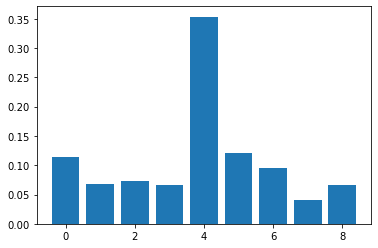

In [25]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [26]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [27]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [28]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [29]:
df5=df5.rename(columns={'index':'Rank'})

In [30]:
df5 #features ranked in order of importance 

,Features,Importance
4,depthfromtopsynset_normalised_x,0.353557
5,glosslength_normalised_x,0.121020
0,ngrams_last_mean,0.114462
6,minwordlength_x,0.095944
2,hypos_normalised,0.073604
1,dir_hypers_normalised,0.068251
3,nrpartrels_normalised_x,0.066997
8,polyscore_max_x,0.066038
7,nroflemmas_x,0.040127


In [32]:
df1.to_csv('results/ex1/cv_ck_aa_global_struct_norm.csv')

In [33]:
report.to_csv('results/ex1/CR_aa_global_struct_norm.csv')

In [34]:
df5.to_csv('results/ex1/FI_aa_global_struct_norm.csv')